## EDA

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### 1. checking the dataset's structure and data types 

In [24]:
data = pd.read_csv('../data/kernel/receivals.csv')

data.head()

,rm_id,product_id,purchase_order_id,purchase_order_item_no,receival_item_no,batch_id,date_arrival,receival_status,net_weight,supplier_id
0,365.0,91900143.0,208545.0,10.0,1,NaN,2004-06-15 13:34:00 +02:00,Completed,11420.0,52062
1,365.0,91900143.0,208545.0,10.0,2,NaN,2004-06-15 13:34:00 +02:00,Completed,13760.0,52062
2,365.0,91900143.0,208490.0,10.0,1,NaN,2004-06-15 13:38:00 +02:00,Completed,11281.0,50468
3,365.0,91900143.0,208490.0,10.0,2,NaN,2004-06-15 13:38:00 +02:00,Completed,13083.0,50468
4,379.0,91900296.0,210435.0,20.0,1,NaN,2004-06-15 13:40:00 +02:00,Completed,23910.0,52577


### 2. Analyzing the missing values

In [10]:
print(data.isnull().sum())

rm_id                        57
product_id                   57
purchase_order_id            53
purchase_order_item_no       53
receival_item_no              0
batch_id                  57825
date_arrival                  0
receival_status               0
net_weight                   68
supplier_id                   0
dtype: int64


### 3. Identifying correlations between numerical values

/tmp/ipykernel_50155/1118366337.py:2: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  data['date_arrival'] = pd.to_datetime(data['date_arrival'], errors='coerce')


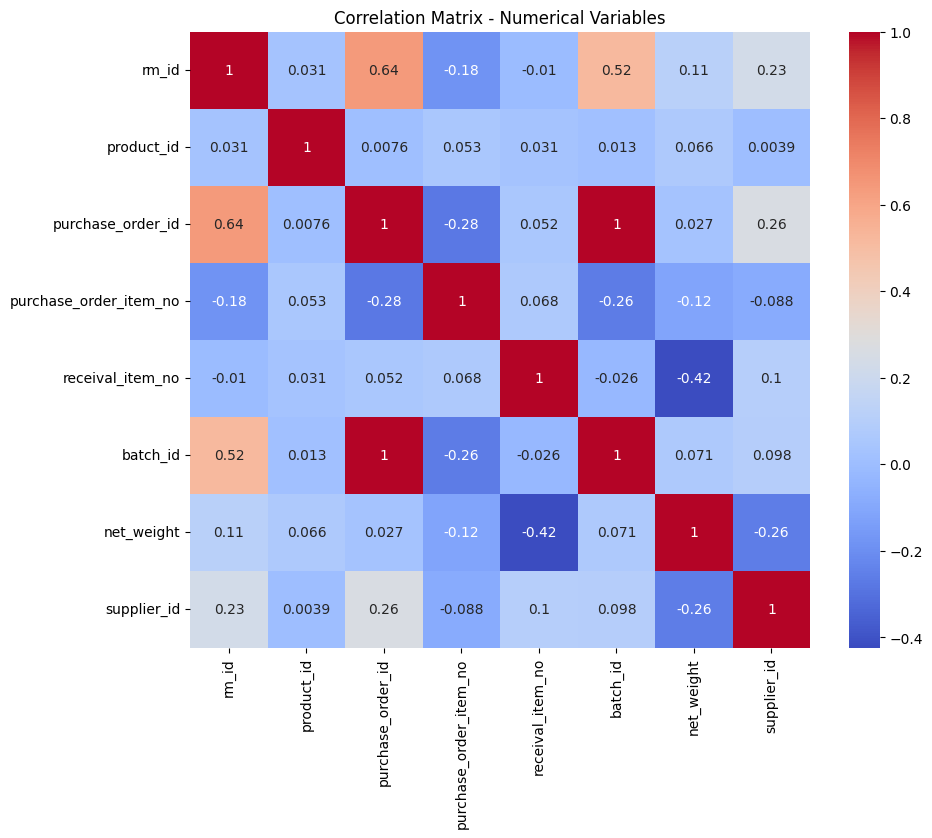

In [19]:
# Converti la colonna datetime in formato corretto
data['date_arrival'] = pd.to_datetime(data['date_arrival'], errors='coerce')

# Calcola la correlazione solo sulle colonne numeriche
numeric_data = data.select_dtypes(include=[np.number])

plt.figure(figsize=(10,8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix - Numerical Variables')
plt.show()

### 4. net weight trend

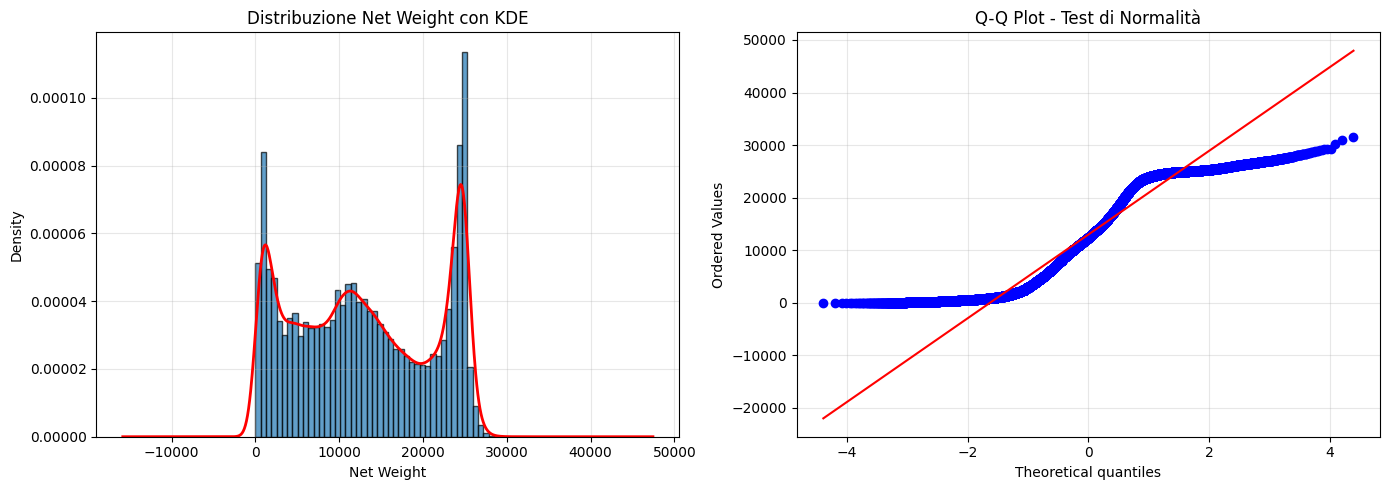


Kolmogorov-Smirnov Test:
Statistica: 0.9989
P-value: 0.0000
Distribuzione normale: No (α=0.05)

Statistiche descrittive:
Media: 12972.57
Mediana: 12380.00
Skewness: 0.07
Kurtosis: -1.31


In [21]:
#data['net_weight'].hist()

# Visualizzazione migliorata dell'istogramma con curva di densità
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Istogramma con KDE
axes[0].hist(data['net_weight'].dropna(), bins=50, edgecolor='black', alpha=0.7, density=True)
data['net_weight'].dropna().plot(kind='kde', ax=axes[0], color='red', linewidth=2)
axes[0].set_xlabel('Net Weight')
axes[0].set_ylabel('Density')
axes[0].set_title('Distribuzione Net Weight con KDE')
axes[0].grid(alpha=0.3)

# Q-Q plot per verificare la normalità
from scipy import stats
stats.probplot(data['net_weight'].dropna(), dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot - Test di Normalità')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Test statistico di normalità (Shapiro-Wilk per campioni < 5000, altrimenti Kolmogorov-Smirnov)
if len(data['net_weight'].dropna()) < 5000:
    stat, p_value = stats.shapiro(data['net_weight'].dropna())
    test_name = "Shapiro-Wilk"
else:
    stat, p_value = stats.kstest(data['net_weight'].dropna(), 'norm')
    test_name = "Kolmogorov-Smirnov"

print(f"\n{test_name} Test:")
print(f"Statistica: {stat:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Distribuzione normale: {'Sì' if p_value > 0.05 else 'No'} (α=0.05)")

# Statistiche descrittive
print(f"\nStatistiche descrittive:")
print(f"Media: {data['net_weight'].mean():.2f}")
print(f"Mediana: {data['net_weight'].median():.2f}")
print(f"Skewness: {data['net_weight'].skew():.2f}")
print(f"Kurtosis: {data['net_weight'].kurtosis():.2f}")

1. La Variabile Target (net_weight) è Ben Comportata
- ✅ Distribuzione simmetrica (Skewness ≈ 0)
- ✅ Media ≈ Mediana: pochi outliers estremi
- ⚠️ Non normale ma appiattita: suggerisce che i pesi sono distribuiti in modo abbastanza uniforme

2. Implicazioni per il Modelling
Puoi usare modelli che NON richiedono normalità:

- ✅ Random Forest, XGBoost, LightGBM: ottimi per questo tipo di dati
- ✅ Neural Networks: gestiscono bene distribuzioni non normali
- ⚠️ Regressione Lineare: potrebbe funzionare ugualmente (è robusta)

NON serve normalizzare la variabile target per la maggior parte dei modelli moderni.

### Temporal analysis of net_weight

/tmp/ipykernel_50155/2447629050.py:9: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['week'] = data['date_arrival'].dt.to_period('W')


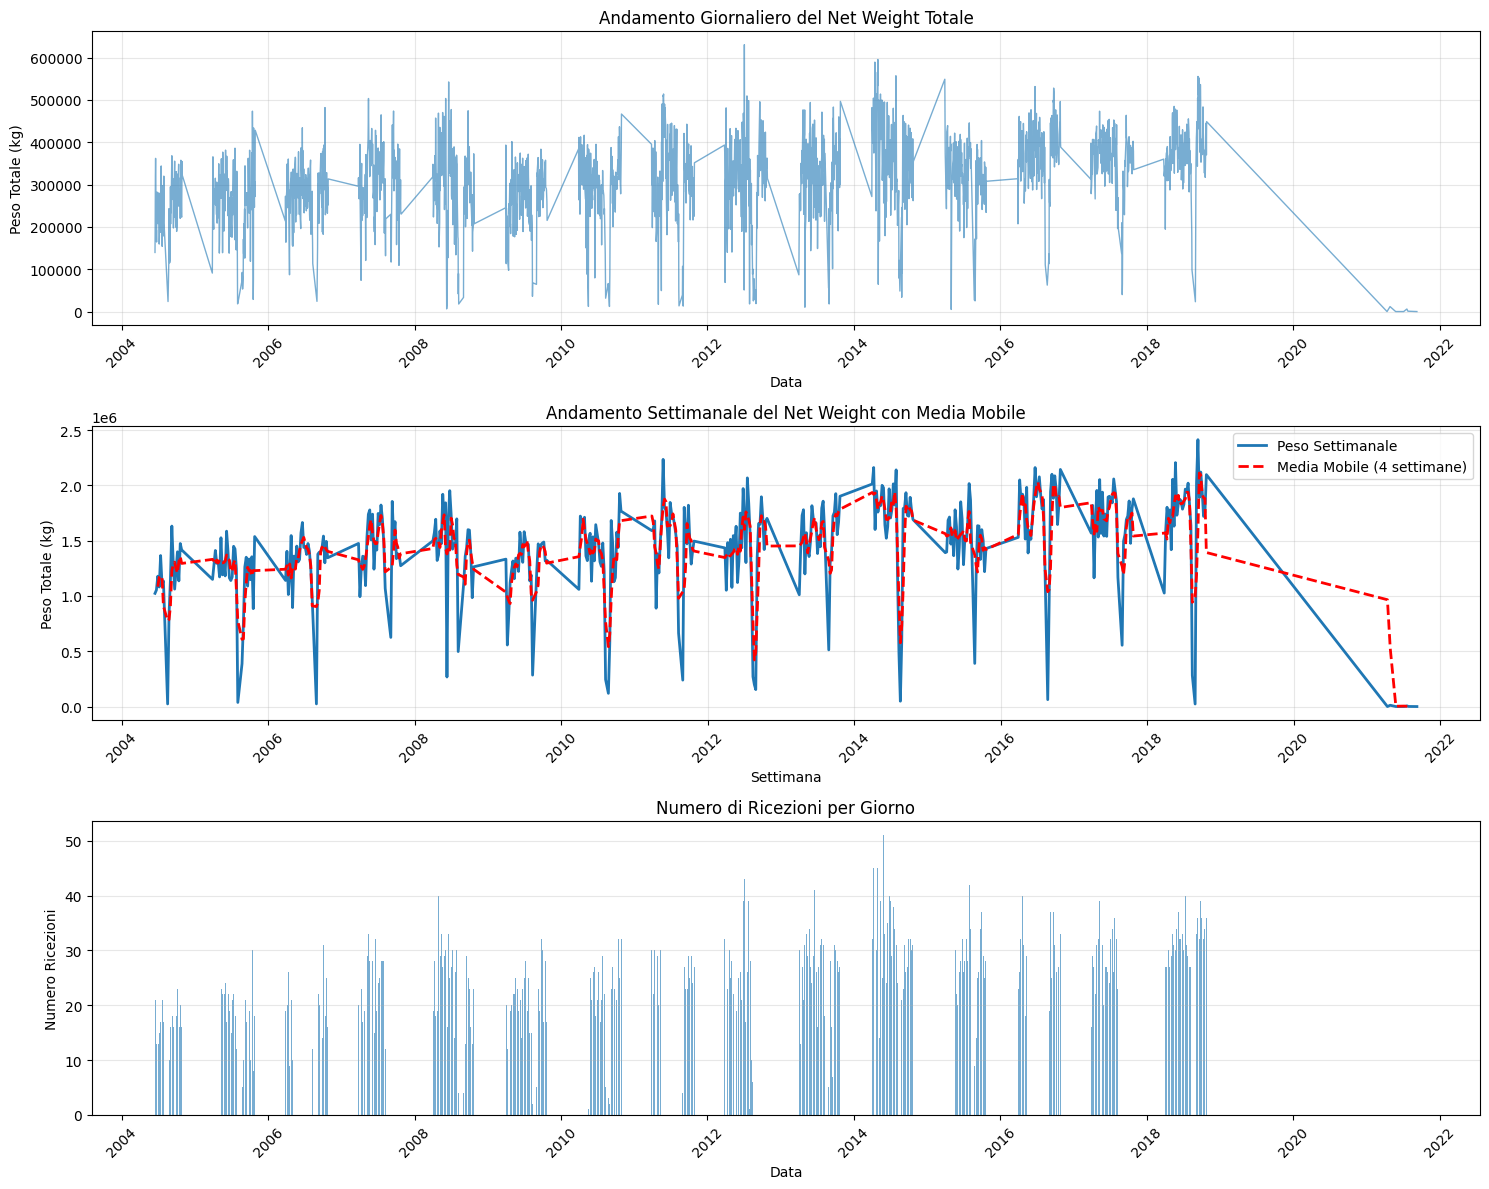


📅 Statistiche Temporali:
Periodo analizzato: 2004-06-15 - 2021-09-09
Durata totale: 6294 giorni

Peso medio giornaliero: 312234.28 kg
Peso mediano giornaliero: 320010.00 kg
Giorno con peso massimo: 2012-07-03 (630488.00 kg)
Giorno con peso minimo: 2021-04-13 (0.00 kg)


In [22]:
# Assicurati che date_arrival sia in formato datetime
data['date_arrival'] = pd.to_datetime(data['date_arrival'], errors='coerce')

# Aggregazione giornaliera
daily_weight = data.groupby(data['date_arrival'].dt.date)['net_weight'].agg(['sum', 'mean', 'count']).reset_index()
daily_weight.columns = ['date', 'total_weight', 'avg_weight', 'num_receivals']

# Aggregazione settimanale
data['week'] = data['date_arrival'].dt.to_period('W')
weekly_weight = data.groupby('week')['net_weight'].agg(['sum', 'mean', 'count']).reset_index()
weekly_weight['week'] = weekly_weight['week'].dt.to_timestamp()

# Visualizzazione
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# 1. Trend giornaliero
axes[0].plot(daily_weight['date'], daily_weight['total_weight'], alpha=0.6, linewidth=1)
axes[0].set_xlabel('Data')
axes[0].set_ylabel('Peso Totale (kg)')
axes[0].set_title('Andamento Giornaliero del Net Weight Totale')
axes[0].grid(alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# 2. Trend settimanale con media mobile
axes[1].plot(weekly_weight['week'], weekly_weight['sum'], label='Peso Settimanale', linewidth=2)
# Media mobile a 4 settimane
weekly_weight['ma_4weeks'] = weekly_weight['sum'].rolling(window=4, center=True).mean()
axes[1].plot(weekly_weight['week'], weekly_weight['ma_4weeks'], 
             label='Media Mobile (4 settimane)', color='red', linewidth=2, linestyle='--')
axes[1].set_xlabel('Settimana')
axes[1].set_ylabel('Peso Totale (kg)')
axes[1].set_title('Andamento Settimanale del Net Weight con Media Mobile')
axes[1].legend()
axes[1].grid(alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

# 3. Numero di ricezioni nel tempo
axes[2].bar(daily_weight['date'], daily_weight['num_receivals'], alpha=0.6)
axes[2].set_xlabel('Data')
axes[2].set_ylabel('Numero Ricezioni')
axes[2].set_title('Numero di Ricezioni per Giorno')
axes[2].grid(alpha=0.3, axis='y')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Statistiche temporali
print("\n📅 Statistiche Temporali:")
print(f"Periodo analizzato: {data['date_arrival'].min().date()} - {data['date_arrival'].max().date()}")
print(f"Durata totale: {(data['date_arrival'].max() - data['date_arrival'].min()).days} giorni")
print(f"\nPeso medio giornaliero: {daily_weight['total_weight'].mean():.2f} kg")
print(f"Peso mediano giornaliero: {daily_weight['total_weight'].median():.2f} kg")
print(f"Giorno con peso massimo: {daily_weight.loc[daily_weight['total_weight'].idxmax(), 'date']} ({daily_weight['total_weight'].max():.2f} kg)")
print(f"Giorno con peso minimo: {daily_weight.loc[daily_weight['total_weight'].idxmin(), 'date']} ({daily_weight['total_weight'].min():.2f} kg)")

### Receival status

🔍 ANALISI RECEIVAL STATUS


Valori unici nella colonna 'receival_status':
['Completed' 'Finished unloading' 'Planned' 'Start unloading']

Numero di stati diversi: 4

📊 Distribuzione degli stati:
  Completed: 122448 (99.88%)
  Finished unloading: 106 (0.09%)
  Start unloading: 32 (0.03%)
  Planned: 4 (0.00%)

📈 Statistiche Net Weight per Receival Status:
   receival_status  count        total         mean  median         std  min     max
         Completed 122438 1588664431.0 12975.256301 12384.5 8263.993946  0.0 31626.0
Finished unloading     75     713639.0  9515.186667  8490.0 8158.207601  0.0 25220.0
           Planned      0          0.0          NaN     NaN         NaN  NaN     NaN
   Start unloading      9      46728.0  5192.000000     0.0 9375.149492  0.0 25372.0


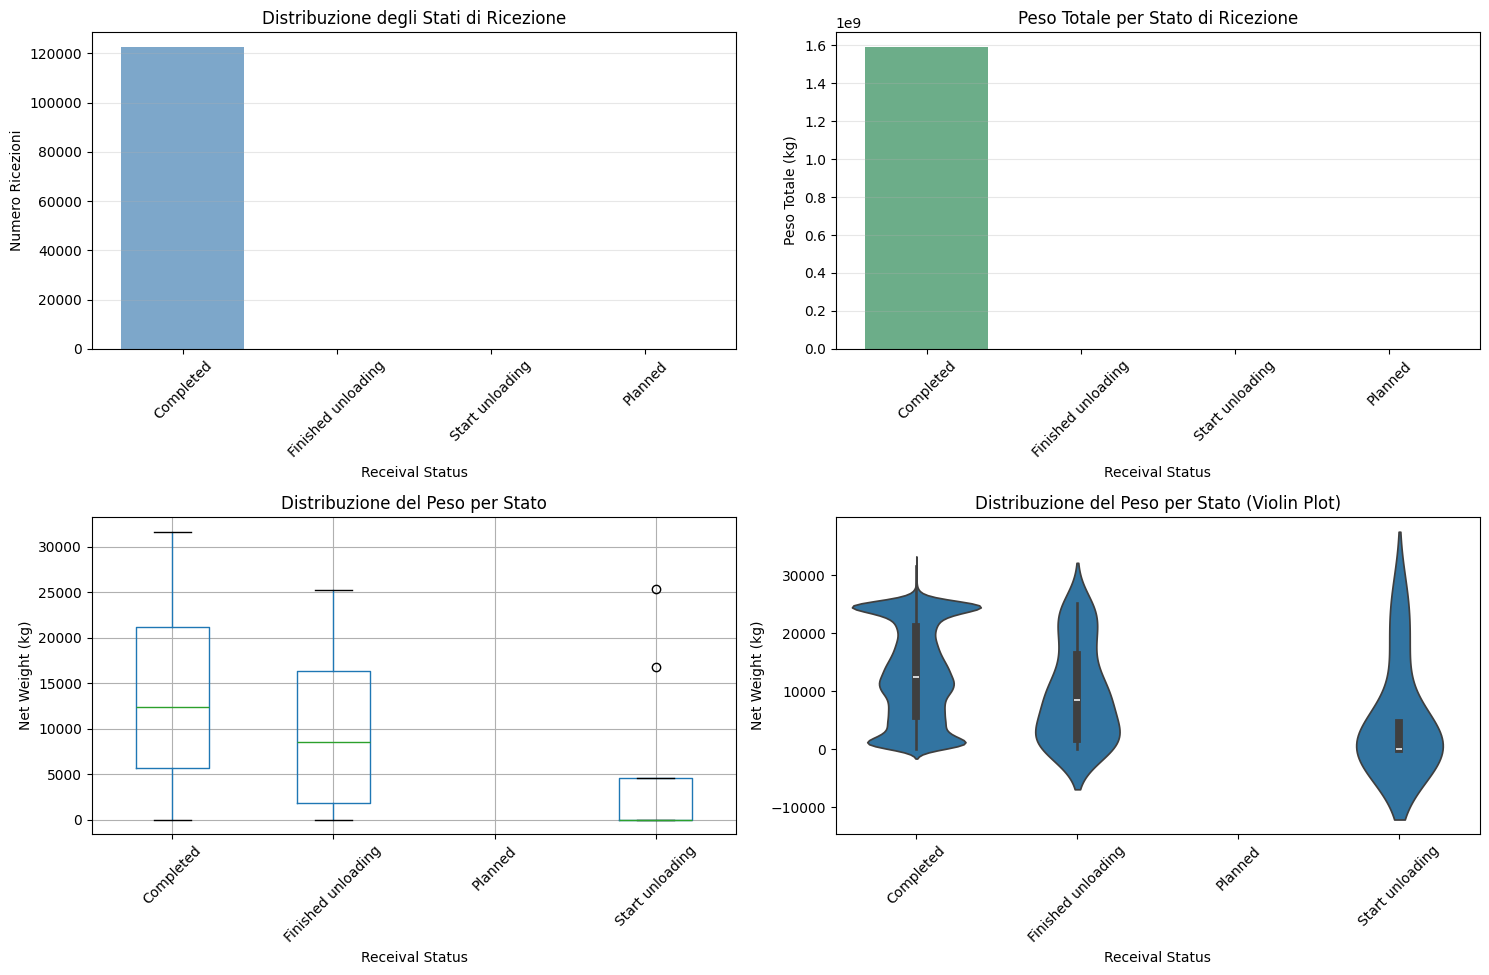


🔬 TEST STATISTICO (ANOVA):
H0: Le medie del net_weight sono uguali per tutti gli stati
H1: Almeno una media è diversa

F-statistic: nan
P-value: nan

Conclusione: Non ci sono differenze significative (α=0.05)

⚠️ STATI CON PESI ANOMALI:

Start unloading:
  - Outliers: 2 (6.25%)
  - Range outliers: [16760.00, 25372.00]


/tmp/ipykernel_50155/1810365980.py:81: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  f_stat, p_value = stats.f_oneway(*groups)


In [23]:
# Verifica valori unici
print("🔍 ANALISI RECEIVAL STATUS\n")
print("=" * 60)
print("\nValori unici nella colonna 'receival_status':")
print(data['receival_status'].unique())
print(f"\nNumero di stati diversi: {data['receival_status'].nunique()}")

# Distribuzione degli stati
status_dist = data['receival_status'].value_counts()
print("\n📊 Distribuzione degli stati:")
for status, count in status_dist.items():
    percentage = (count / len(data)) * 100
    print(f"  {status}: {count} ({percentage:.2f}%)")

# Analisi del peso per stato
status_weight = data.groupby('receival_status')['net_weight'].agg([
    ('count', 'count'),
    ('total', 'sum'),
    ('mean', 'mean'),
    ('median', 'median'),
    ('std', 'std'),
    ('min', 'min'),
    ('max', 'max')
]).reset_index()

print("\n📈 Statistiche Net Weight per Receival Status:")
print(status_weight.to_string(index=False))

# Visualizzazione
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Distribuzione degli stati
axes[0, 0].bar(status_dist.index, status_dist.values, color='steelblue', alpha=0.7)
axes[0, 0].set_xlabel('Receival Status')
axes[0, 0].set_ylabel('Numero Ricezioni')
axes[0, 0].set_title('Distribuzione degli Stati di Ricezione')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(alpha=0.3, axis='y')

# 2. Peso totale per stato
total_by_status = data.groupby('receival_status')['net_weight'].sum().sort_values(ascending=False)
axes[0, 1].bar(total_by_status.index, total_by_status.values, color='seagreen', alpha=0.7)
axes[0, 1].set_xlabel('Receival Status')
axes[0, 1].set_ylabel('Peso Totale (kg)')
axes[0, 1].set_title('Peso Totale per Stato di Ricezione')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(alpha=0.3, axis='y')

# 3. Boxplot del peso per stato
data.boxplot(column='net_weight', by='receival_status', ax=axes[1, 0])
axes[1, 0].set_xlabel('Receival Status')
axes[1, 0].set_ylabel('Net Weight (kg)')
axes[1, 0].set_title('Distribuzione del Peso per Stato')
axes[1, 0].get_figure().suptitle('')  # Rimuovi titolo automatico
plt.setp(axes[1, 0].xaxis.get_majorticklabels(), rotation=45)

# 4. Violin plot per confronto distribuzioni
import seaborn as sns
sns.violinplot(data=data, x='receival_status', y='net_weight', ax=axes[1, 1])
axes[1, 1].set_xlabel('Receival Status')
axes[1, 1].set_ylabel('Net Weight (kg)')
axes[1, 1].set_title('Distribuzione del Peso per Stato (Violin Plot)')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Test statistico per verificare differenze significative tra gli stati
from scipy import stats

print("\n🔬 TEST STATISTICO (ANOVA):")
print("=" * 60)
print("H0: Le medie del net_weight sono uguali per tutti gli stati")
print("H1: Almeno una media è diversa\n")

# Raggruppa i pesi per stato
groups = [data[data['receival_status'] == status]['net_weight'].dropna() 
          for status in data['receival_status'].unique()]

# ANOVA
f_stat, p_value = stats.f_oneway(*groups)
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"\nConclusione: {'Le medie sono significativamente diverse' if p_value < 0.05 else 'Non ci sono differenze significative'} (α=0.05)")

# Identifica stati anomali
print("\n⚠️ STATI CON PESI ANOMALI:")
print("=" * 60)
for status in data['receival_status'].unique():
    status_data = data[data['receival_status'] == status]['net_weight']
    Q1 = status_data.quantile(0.25)
    Q3 = status_data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = status_data[(status_data < Q1 - 1.5*IQR) | (status_data > Q3 + 1.5*IQR)]
    
    if len(outliers) > 0:
        print(f"\n{status}:")
        print(f"  - Outliers: {len(outliers)} ({len(outliers)/len(status_data)*100:.2f}%)")
        print(f"  - Range outliers: [{outliers.min():.2f}, {outliers.max():.2f}]")